<a href="https://colab.research.google.com/github/caangonzalez1/data_analysis/blob/main/SPANi_3DVDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***install needed packages***

In [ ]:
pip install cdflib;pip install wget;pip install cdasws;#pip install cartopy

# ***Import libraries and packages***

In [2]:
import matplotlib.pyplot as plt
import sys
sys.maxsize > 0x100000000
import gzip
import numpy as np
import os
import subprocess
import pandas as pd
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython import get_ipython;
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm
import scipy.fftpack as fft
import _pickle as pickle
import datetime
import cdflib
import bisect
#import heliopy.data.spice as spicedata
#import heliopy.spice as spice
from datetime import datetime, timedelta
import astropy.units as u
from scipy.interpolate import interp1d
sys.path.insert(1,'/content/drive/MyDrive/space_missions/DATA/Python_for_data')
import wget
#import switchbackcode as sb
#import statistics as s
from glob import glob
import ntpath
from numba import jit
os.environ["CDF_LIB"] = '/content/drive/MyDrive/space_missions/cdf37_1-dist/lib'
#from spacepy import pycdf
#from matplotlib.colors import LogNorm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
class AllNanAxisWarning(RuntimeWarning):
    pass
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cdasws import CdasWs
cdas = CdasWs()

# ***Define some functions:***

In [3]:
def hampel_filter(input_series, window_size, n_sigmas=2):
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    # possibly use np.nanmedian
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    return new_series, indices
    
    
def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original)-1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int) #Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor #Remain

    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0-index_rem) + val2 * index_rem
    assert(len(interp) == targetLen)
    return interp
    
def slid_av_local(den,delta_i):
    sizarr = len(den)
    den_av = zeros([sizarr])
    windowtime=delta_i
    nsteps=sizarr/windowtime
    s0=0;
    for i in range(0,sizarr,1):
        s0=0
        if (i-int(windowtime/2)<0):
            dif_tmp = (i-int(windowtime))
            a_ind = 0
            b_ind = i + windowtime
            j=a_ind
            while (j<=b_ind):
                s0 = s0 + den[j]
                j=j+1
            den_av[i] = s0/windowtime
        elif (i+int(windowtime/2)>sizarr-1):
            a_ind = (sizarr-1)-int(windowtime)
            b_ind = (sizarr-1)
            j= a_ind
            while (j<=b_ind):
                s0 = s0 + den[j]
                j=j+1
            den_av[i] = s0/windowtime
        elif((i-int(windowtime/2))>=0 and (i+int(windowtime/2)<=sizarr-1)):
            a_ind = (i-int(windowtime/2))
            b_ind = (i+int(windowtime/2))
            j=a_ind
            while (j<=b_ind):
                s0 = s0 + den[j]
                j=j+1
            den_av[i] = s0/windowtime
        else:
            print('none')

    return den_av
        
def vdf_int_t(k,v_arr,vz_arr,data3D_arr,epoch_range,vmin,vmax,vzmin,vzmax):

    amp_resc = 1.0;
    v_range = [vmin,vmax]
    vz_range = [vzmin,vzmax]    
    xnew = np.linspace(v_range[0],v_range[1], 256)
    ynew = np.linspace(vz_range[0],vz_range[1], 256)
    arr_tmp_vdf = np.zeros([8,len(xnew)])
    arr_tmp_vdf2 = np.zeros([len(ynew),len(xnew)])
    vdf_int =np.zeros([8,8,len(xnew)])
    vdf_int2 =np.zeros([8,len(ynew),len(xnew)]) 
    #print(k)
    #interpolate the x-direction
    for i in range(1,8):
        map_2D_init = data3D_arr[k,i,:,:]
        vx_ax2D = v_arr[k,i,:,:]
        for j in range(8):
            map_1D = map_2D_init[:,j]
            vx_ax = vx_ax2D[:,j]
            f = interpolate.interp1d(vx_ax,map_1D,kind = "cubic",bounds_error=False,fill_value=0)
            ytmp = f(xnew)
            arr_tmp_vdf[j,:] = ytmp
        vdf_int[i,:,:] = arr_tmp_vdf
    #interpolate the y-direction
    for i in range(8):
        map_2D = vdf_int[i,:,:]
        vz_ax2D = vz_arr[k,i,:,:]
        vz_ax2D_new = resize_array(vz_ax2D,len(ynew),8)
        for j in range(len(ynew)):
            map_1D = map_2D[:,j]
            vz_ax = vz_ax2D_new[j,:]
            f = interpolate.interp1d(vz_ax,map_1D,kind = "cubic",bounds_error=False, fill_value=0)
            ytmp = f(ynew)
            arr_tmp_vdf2[:,j] = ytmp
        vdf_int2[i,:,:] = arr_tmp_vdf2
        
    return  xnew,ynew,vdf_int2
  
def vdf_int_xy_t(k,v_arr,vz_arr,data3D_arr,epoch_range,vmin,vmax,vzmin,vzmax):

    amp_resc = 1.0;
    v_range = [vmin,vmax]
    vz_range = [vzmin,vzmax]
    xnew = np.linspace(v_range[0],v_range[1], 256)
    ynew = np.linspace(vz_range[0],vz_range[1], 256)
    arr_tmp_vdf = np.zeros([8,len(xnew)])
    arr_tmp_vdf2 = np.zeros([len(ynew),len(xnew)])
    vdf_int =np.zeros([8,8,len(xnew)])
    vdf_int2 =np.zeros([8,len(ynew),len(xnew)])
    #print(k)
    #interpolate the x-direction
    for i in range(8):
        map_2D_init = data3D_arr[k,:,:,i]
        vx_ax2D = v_arr[k,:,:,i]
        for j in range(8):
            map_1D = map_2D_init[j,:]
            vx_ax = vx_ax2D[j,:]
            f = interpolate.interp1d(vx_ax,map_1D,kind = "cubic",bounds_error=False,fill_value=0)
            ytmp = f(xnew)
            arr_tmp_vdf[j,:] = ytmp
        vdf_int[i,:,:] = arr_tmp_vdf
    #interpolate the y-direction
    for i in range(8):
        map_2D = vdf_int[i,:,:]
        vz_ax2D = vz_arr[k,:,:,i]
        vz_ax2D_new = resize_array(vz_ax2D,8,len(ynew))
        for j in range(len(ynew)):
            map_1D = map_2D[:,j]
            vz_ax = vz_ax2D_new[:,j]
            f = interpolate.interp1d(vz_ax,map_1D,kind = "cubic",bounds_error=False, fill_value=0)
            ytmp = f(ynew)
            arr_tmp_vdf2[:,j] = ytmp
            art_tmp = arr_tmp_vdf2
        vdf_int2[i,:,:] = (art_tmp)
 
    return  xnew,ynew,vdf_int2

def resize_array(a, new_rows, new_cols):

    rows = len(a)
    cols = len(a[0])
    yscale = float(rows) / new_rows
    xscale = float(cols) / new_cols
    new_a = np.zeros((rows, new_cols))
    for j in range(new_cols):
        the_x_range = (j*xscale, (j+1)*xscale)
        firstx = int(the_x_range[0])
        lastx = int(the_x_range[1])
        x0_scale = 1 - (the_x_range[0]-int(the_x_range[0]))
        xEnd_scale =  (the_x_range[1]-int(the_x_range[1]))
        scale_line = np.ones((lastx-firstx+1))
        scale_line[0] = x0_scale
        scale_line[-1] = xEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lastx = lastx - 1
        new_a[:,j] = np.dot(a[:,firstx:lastx+1], scale_line)/scale_line.sum()

    a = np.zeros((new_rows, new_cols))
    for i in range(new_rows):
        the_y_range = (i*yscale, (i+1)*yscale)
        firsty = int(the_y_range[0])
        lasty = int(the_y_range[1])
        y0_scale = 1 - (the_y_range[0]-int(the_y_range[0]))
        yEnd_scale =  (the_y_range[1]-int(the_y_range[1]))
        scale_line = np.ones((lasty-firsty+1))
        scale_line[0] = y0_scale
        scale_line[-1] = yEnd_scale
        if scale_line[-1] == 0:
            scale_line = scale_line[:-1]
            lasty = lasty - 1
        a[i:,] = np.dot(scale_line, new_a[firsty:lasty+1,])/scale_line.sum()
    return a

def angle_vect12(vector_1,vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.rad2deg(np.arccos(dot_product))
    return angle   
 

# ***some constants:***

In [4]:
m_proton = 1.673*1e-27 # kg
m_electron = m_proton/1836
q_proton = 1.602*1e-19 # A.s
mu_0 = 4*np.pi*1e-7 # H/m
k_boltz = 1.3806*1e-23 # J/K
c0 = 3e8 #m/s
epsilon0 = 1./(mu_0*c0*c0)

# ***Define the tine interval you want to study:***

In [30]:
starttime = "2020-09-27 10:00:00"
endtime = "2020-09-27 11:20:00"
starttime0 = '2020-09-27T10:00:00.000Z'
endtime0 = '2020-09-27T11:20:00.000Z'
import datetime
start = datetime.datetime(2020,9,27,10,0)
stop  = datetime.datetime(2020,9,27,11,20)
time = [starttime0,endtime0]

Getting proton VDFs data....

In [6]:
VDfile_directoryRemote = 'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/2020/09/'
VDfile_filename = 'psp_swp_spi_sf00_L2_8Dx32Ex8A_20200927_v03.cdf'
if os.path.isfile(VDfile_filename):
    print("File exists")
    VDfile = VDfile_filename
else:
    print("File doesn't exist... getting it")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)
cdf_VDfile = cdflib.CDF(VDfile)
#print(cdf_VDfile)
dat = cdflib.CDF(VDfile)
#print(dat._get_varnames())    


File doesn't exist... getting it


Getting proton moment data obtained from the repository....



In [31]:
vars = ['DENS','VEL_INST','MAGF_INST','VEL_RTN_SUN','SC_VEL_RTN_SUN','VEL_SC']
status,data= cdas.get_data('PSP_SWP_SPI_SF00_L3_MOM',vars,time[0],time[1])
time_spi = data['Epoch'][:] # time SPI
time_tp = np.array(time_spi, dtype='int64')
cdf_file = cdflib.cdfepoch.breakdown_tt2000(time_tp)
time_spi = cdf_file
epoch_tmp = []
for i in range(len(time_spi)):   
    arrat = np.array(time_spi[i]);
    etrr = datetime.datetime(arrat[0],arrat[1],arrat[2],arrat[3],arrat[4],arrat[5])
    epoch_tmp.append(etrr)
time_spi = epoch_tmp
MAG_spi = data['MAGF_INST'][:] # B field instrument frame
VEL_spi = data['VEL_INST'][:] # V field instrument frame
VEL_rtn = data['VEL_RTN_SUN'][:] # V field instrument frame
VEL_spc = data['VEL_SC'][:] #velocoty spacecraft frame
VEL_sc = data['SC_VEL_RTN_SUN'][:] #spacecraft velocity in RTN
den_spi = data['DENS'][:] # rho SPI


#proton bulk velocity in the instrument frame
uxi_tmp = VEL_spi[:,0]
uyi_tmp = VEL_spi[:,1]
uzi_tmp = VEL_spi[:,2]
#proton bulk velocity in spacecraft frame
uxs_tmp = VEL_spc[:,0]
uys_tmp = VEL_spc[:,1]
uzs_tmp = VEL_spc[:,2]
#proton bulk velocity in RTN frame
ur_tmp = VEL_rtn[:,0]
ut_tmp = VEL_rtn[:,1]
un_tmp = VEL_rtn[:,2]
#spacecraft velocity in RTN frame
sc_r = VEL_sc[:,0]
sc_t = VEL_sc[:,1]
sc_n = VEL_sc[:,2]

df_spi = pd.DataFrame({'time':time_spi,'ni':den_spi,'bx':MAG_spi[:,0],'by':MAG_spi[:,1],'bz':MAG_spi[:,2],'vx':VEL_spi[:,0],'vy':VEL_spi[:,1],'vz':VEL_spi[:,2]})
#df_spi  = df_spi.interpolate(method='linear')
B = np.sqrt(df_spi['bx']**2 + df_spi['by']**2 + df_spi['bz']**2)
bx_tmp = np.array(df_spi['bx'])
by_tmp = np.array(df_spi['by'])
bz_tmp = np.array(df_spi['bz'])
vx_tmp = np.array(df_spi['vx'])
vy_tmp = np.array(df_spi['vy'])
vz_tmp = np.array(df_spi['vz'])
rho = m_proton*1e6*df_spi['ni'] # kg m^{-3}
B_tmp = np.sqrt((df_spi['bx']*1e-9)**2 + (df_spi['by']*1e-9)**2 + (df_spi['bz']*1e-9)**2)
v_A = B_tmp/(np.sqrt(mu_0*rho))*1e-3

bxn = bx_tmp/B; byn = by_tmp/B;bzn = bz_tmp/B

Read and collect the VDF's data for the period of interest 

In [32]:
epoch           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']


time_tp = np.array(epoch, dtype='int64')
cdf_file = cdflib.cdfepoch.breakdown_tt2000(time_tp)
epoch = cdf_file
epoch_tmp = []
for i in range(len(epoch)):   
    arrat = np.array(epoch[i]);
    etrr = datetime.datetime(arrat[0],arrat[1],arrat[2],arrat[3],arrat[4],arrat[5])
    epoch_tmp.append(etrr)
epoch = epoch_tmp
print
# datetime(YYYY, mm, dd, HH, MM)
startIndex = bisect.bisect_left(epoch, start)
stopIndex  = bisect.bisect_left(epoch, stop)


epoch_range = epoch[startIndex:stopIndex]
Epoch_spiL2 = epoch_range
Theta_spiL2 = theta[startIndex:stopIndex]
Phi_spiL2 =  phi[startIndex:stopIndex]
Energy_spiL2 = energy[startIndex:stopIndex]
Eflux_spiL2 = eflux[startIndex:stopIndex]

data3D_array =  np.zeros([len(Epoch_spiL2), 8, 32, 8])
phi_array =  np.zeros([len(Epoch_spiL2), 8, 32, 8])
theta_array  =  np.zeros([len(Epoch_spiL2), 8, 32, 8])
Eflux_array = np.zeros([len(epoch_range),8, 32, 8])
energy_array  = np.zeros([len(epoch_range),8, 32, 8])
velocity_array  =  np.zeros([len(Epoch_spiL2), 8, 32, 8])
vx_array = np.zeros([len(Epoch_spiL2),8, 32, 8])
vy_array = np.zeros([len(Epoch_spiL2),8, 32, 8])
vz_array = np.zeros([len(Epoch_spiL2),8, 32, 8])

i=0
for ii in range(0,len(Epoch_spiL2)-1):
    #print(i,ii)
    Eflux_array[i,:,:,:] = np.reshape(Eflux_spiL2[ii,:],[8,32,8])
    phi_array[i,:,:,:] =  np.reshape(Phi_spiL2[ii,:],[8,32,8])
    theta_array[i,:,:,:]  = np.reshape(Theta_spiL2[ii,:],[8,32,8])
    energy_array[i,:,:,:] = np.reshape(Energy_spiL2[ii,:],[8,32,8])
    i=i+1

mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
charge_p = 1              #eV
#Define VDF
numberFlux = Eflux_array/energy_array
vdf = numberFlux#*(mass_p**2)/((2E-5)*energy_array)
vel = np.sqrt(2*charge_p*energy_array/mass_p)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


# Transform the 3D spherical VDF ( $\theta,\phi,E$) into cartesian coordinates ($v_x,v_y_v_z$): Then obtain the VDF rotated into different frames

In [ ]:
for ii in range(0,len(Epoch_spiL2)-1):
    int_tmp = 0
    for i in range(0,8):
        for j in range(0,32):
            for k in range(0,8):
                #print(ii,int_tmp)
                data3D_array[ii,i,j,k] = vdf[ii,i,j,k]
                velocity_array[ii,i,j,k] = vel[ii,i,j,k]
                theta_tmp = np.deg2rad(theta_array[ii,i,j,k])
                phi_tmp =  np.deg2rad(phi_array[ii,i,j,k])
                v_tmp = velocity_array[ii,i,j,k] #- psp_vel_resampled[ii]
                vx_array[ii,i,j,k] = v_tmp*np.cos(theta_tmp)*np.cos(phi_tmp)
                vy_array[ii,i,j,k] = v_tmp*np.cos(theta_tmp)*np.sin(phi_tmp)
                vz_array[ii,i,j,k] = v_tmp*np.sin(theta_tmp)
                int_tmp = int_tmp + 1

vx_array_tmp = np.nan_to_num(vx_array)
vy_array_tmp = np.nan_to_num(vy_array)
vz_array_tmp = np.nan_to_num(vz_array)
v_array_tmp = np.nan_to_num(velocity_array)
data3D_array_tmp = np.nan_to_num(data3D_array)
data3D_rot = data3D_array_tmp


#transform from instrument (SPAN-i) to spacecraft frame (SPC)
thetaaa=20
rot_mat = np.array([[0,-np.cos(np.deg2rad(thetaaa)),-np.sin(np.deg2rad(thetaaa))],
                [0, np.sin(np.deg2rad(thetaaa)), -np.cos(np.deg2rad(thetaaa))],
                [1, 0, 0]])

vx_rot = np.zeros([len(Epoch_spiL2),8, 32, 8])
vy_rot = np.zeros([len(Epoch_spiL2),8, 32, 8])
vz_rot = np.zeros([len(Epoch_spiL2),8, 32, 8])
for nt in range (len(Epoch_spiL2)):
     #print (nt)
     for i in range(8):
        for j in range(32):
            for k in range(8):
                c = np.array([vx_array_tmp[nt,i,j,k],vy_array_tmp[nt,i,j,k],vz_array_tmp[nt,i,j,k]])
                d = np.dot(rot_mat,c)
                vx_rot[nt,i,j,k] = d[0]
                vy_rot[nt,i,j,k] = d[1]
                vz_rot[nt,i,j,k] = d[2]


#transform to RTN frame and remove
#spacecraft velocity in the RTN frame
sc_r_resampled = ResampleLinear1D(sc_r,len(Epoch_spiL2))
sc_t_resampled = ResampleLinear1D(sc_t,len(Epoch_spiL2))
sc_n_resampled = ResampleLinear1D(sc_n,len(Epoch_spiL2))

vr_tmp = np.zeros([len(Epoch_spiL2),8, 32, 8])
vt_tmp = np.zeros([len(Epoch_spiL2),8, 32, 8])
vn_tmp = np.zeros([len(Epoch_spiL2),8, 32, 8])
for nt in range (len(Epoch_spiL2)):
    #print (nt)
    for i in range(8):
        for j in range(32):
            for k in range(8):
                vr_tmp[nt,i,j,k] =  (-1.0*vz_rot[nt,i,j,k]) + sc_r_resampled[nt]
                vt_tmp[nt,i,j,k] = vx_rot[nt,i,j,k] + sc_t_resampled[nt]
                vn_tmp[nt,i,j,k] = (-1.0*vy_rot[nt,i,j,k]) + sc_n_resampled[nt]



#transform from instrument (SPAN-i) to Field-aligned frame
bx_n = ResampleLinear1D(bxn,len(Epoch_spiL2))
by_n = ResampleLinear1D(byn,len(Epoch_spiL2))
bz_n = ResampleLinear1D(bzn,len(Epoch_spiL2))

vx_rot_FR = np.zeros([len(Epoch_spiL2),8, 32, 8])
vy_rot_FR = np.zeros([len(Epoch_spiL2),8, 32, 8])
vz_rot_FR = np.zeros([len(Epoch_spiL2),8, 32, 8])
vector1 = [-1,0,0]
for nt in range (len(Epoch_spiL2)):
     kx = 0; ky = -bz_n[nt]; kz = by_n[nt]
     km = np.sqrt(ky**2 + kz**2)
     kxn = 0; kyn = ky/km;  kzn = kz/km
     vector2_tmp = [bx_n[nt],by_n[nt],bz_n[nt]]
     thetaaa = (angle_vect12(vector1,vector2_tmp))
     thetaaa = thetaaa
     print(nt,thetaaa)
     for i in range(8):
        for j in range(32):
            for k in range(8):
                c = np.array([vx_array_tmp[nt,i,j,k],vy_array_tmp[nt,i,j,k],vz_array_tmp[nt,i,j,k]])
                rot_mat_x = np.array([[np.cos(np.deg2rad(thetaaa)),-kzn*np.sin(np.deg2rad(thetaaa)),kyn*np.sin(np.deg2rad(thetaaa))],[kzn*np.sin(np.deg2rad(thetaaa)),(kyn**2 + kzn**2)*np.cos(np.deg2rad(thetaaa)),kyn*kzn*(1.0-np.cos(np.deg2rad(thetaaa)))],[-kyn*np.sin(np.deg2rad(thetaaa)), kyn*kzn*(1.0-np.cos(np.deg2rad(thetaaa))), (kyn**2 + kzn**2)*np.cos(np.deg2rad(thetaaa))]])
                d = np.dot(rot_mat_x,c)
                vx_rot_FR[nt,i,j,k] = d[0]
                vy_rot_FR[nt,i,j,k] = d[1]
                vz_rot_FR[nt,i,j,k] = d[2]





# ***Plotting the projection of the proton VDF at the selected interval in all three frames.***

The red dots represent the proton velocity in each frame of reference obtained from the repository. (are these moments obtained assuming a single maxwellian VDF?)

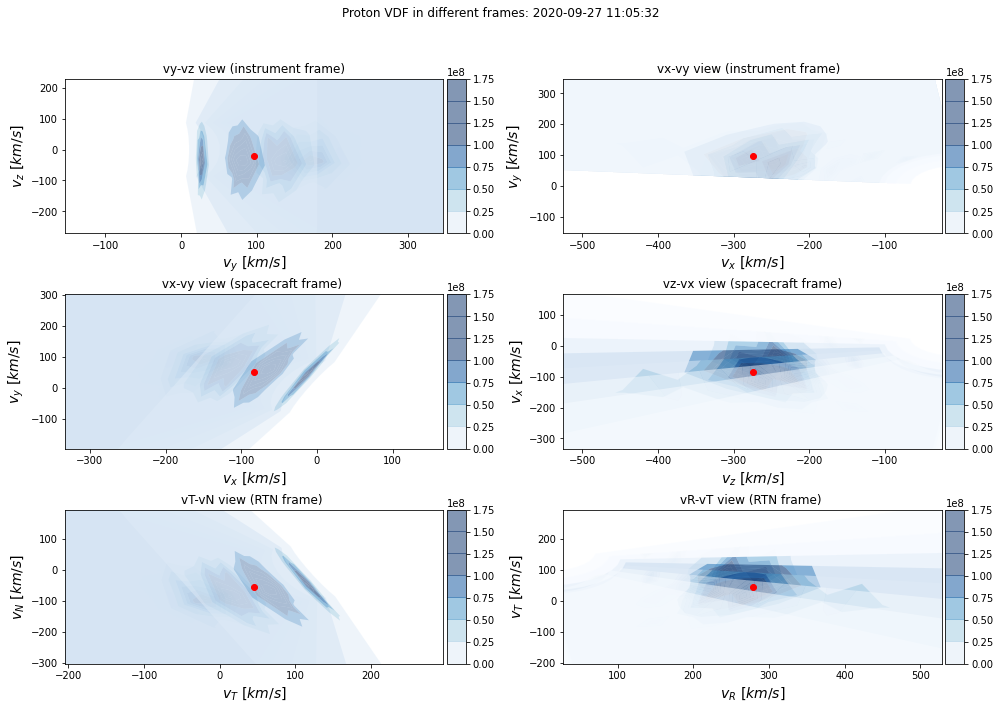

In [41]:
#plot VDF at single time slice at different reference frames:
import datetime
timeSlice = datetime.datetime(2020, 9, 27, 11, 5,32)
tSliceIndex  = bisect.bisect_left(epoch_range, timeSlice)
tSliceIndex_mom  = bisect.bisect_left(time_spi, timeSlice)
epoch_range[tSliceIndex]
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
deltav = 250
alphap= 0.5
fig = plt.figure(figsize=(14, 10))
ax11 = fig.add_subplot(321)
ax21 = fig.add_subplot(322)
ax12 = fig.add_subplot(323)
ax22 = fig.add_subplot(324)
ax13 = fig.add_subplot(325)
ax23 = fig.add_subplot(326)
ax11.clear()
ax21.clear()
ax12.clear()
ax22.clear()
ax13.clear()
ax23.clear()
ax11.set_title(" vy-vz view (instrument frame) ")
ax21.set_title("vx-vy view (instrument frame)  ")
ax12.set_title(" vx-vy view (spacecraft frame)  ")
ax22.set_title(" vz-vx view (spacecraft frame) ")
ax13.set_title("vT-vN view (RTN frame) ")
ax23.set_title("vR-vT view (RTN frame) ")
fig.suptitle('Proton VDF in different frames:'+' '+str(ttt)[:19],Fontsize=20)
ttt = epoch_range[tSliceIndex]
#plot VDF at t=epoch_range[tSliceIndex] in the instrument frame
#v_a,vz_a,vdf_vz =  vdf_int_t(tSliceIndex,vy_array_tmp,vz_array_tmp,data3D_rot,epoch_range,50,250,-500,500)
#vx_a,vy_a,vdf_xy =  vdf_int_xy_t(tSliceIndex,vx_array_tmp,vy_array_tmp,data3D_rot,epoch_range,-500,-100,0,300)
for i in reversed(range(8)):
    im11 = ax11.contourf(vy_array_tmp[tSliceIndex,i,:,:],vz_array_tmp[tSliceIndex,i,:,:],data3D_array_tmp[tSliceIndex,i,:,:],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = uyi_tmp[tSliceIndex_mom]
ylay = uzi_tmp[tSliceIndex_mom]
ims11 = ax11.plot(xlay,ylay,'or')
ax11.set_xlim([xlay-deltav,xlay+deltav])
ax11.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax11)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im11, cax=cax, orientation='vertical')
ax11.set_xlabel(r'$v_y \  [km/s]$',Fontsize=14)
ax11.set_ylabel(r'$v_z \  [km/s]$',Fontsize=14)
for i in reversed(range(8)):
    im21 = ax21.contourf(vx_array_tmp[tSliceIndex,:,:,i],vy_array_tmp[tSliceIndex,:,:,i],data3D_array_tmp[tSliceIndex,:,:,i],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = uxi_tmp[tSliceIndex_mom]
ylay = uyi_tmp[tSliceIndex_mom]
ims21 = ax21.plot(xlay,ylay,'or')
ax21.set_xlim([xlay-deltav,xlay+deltav])
ax21.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax21)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im11, cax=cax, orientation='vertical');
ax21.set_xlabel(r'$v_x \  [km/s]$',Fontsize=14)
ax21.set_ylabel(r'$v_y \  [km/s]$',Fontsize=14)
#fig.suptitle('proton VDF in instrument frame:'+'  '+str(ttt)[:19],Fontsize=14)
#plot VDF at t=epoch_range[tSliceIndex] in the spacecraft frame
#v_a,vz_a,vdf_vz =  vdf_int_t(tSliceIndex,vx_rot,vy_rot,data3D_rot,epoch_range,-250,0,-300,300)
#vx_a,vy_a,vdf_xy =  vdf_int_xy_t(tSliceIndex,vz_rot,vx_rot,data3D_rot,epoch_range,-400,-100,-400,0)
#im12 = ax12.contourf(((np.sum(vdf_vz,axis=0))),origen='lower',cmap='Blues',extent=[np.min(v_a),np.max(v_a),np.min(vz_a),np.max(vz_a)])
#ims12 = ax12.plot(uxs_tmp[tSliceIndex_mom],uys_tmp[tSliceIndex_mom],'or')
for i in reversed(range(8)):
    im12 = ax12.contourf(vx_rot[tSliceIndex,i,:,:],vy_rot[tSliceIndex,i,:,:],data3D_rot[tSliceIndex,i,:,:],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = uxs_tmp[tSliceIndex_mom]
ylay = uys_tmp[tSliceIndex_mom]
ims12 = ax12.plot(xlay,ylay,'or')
ax12.set_xlim([xlay-deltav,xlay+deltav])
ax12.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax12)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im11, cax=cax, orientation='vertical')
ax12.set_xlabel(r'$v_x \  [km/s]$',Fontsize=14)
ax12.set_ylabel(r'$v_y \  [km/s]$',Fontsize=14)
for i in (range(8)):
    im22 = ax22.contourf(vz_rot[tSliceIndex,:,:,i],vx_rot[tSliceIndex,:,:,i],data3D_rot[tSliceIndex,:,:,i],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = uzs_tmp[tSliceIndex_mom]
ylay = uxs_tmp[tSliceIndex_mom]
ims22 = ax22.plot(xlay,ylay,'or')
ax22.set_xlim([xlay-deltav,xlay+deltav])
ax22.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax22)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im11, cax=cax, orientation='vertical');
ax22.set_xlabel(r'$v_z \  [km/s]$',Fontsize=14)
ax22.set_ylabel(r'$v_x \  [km/s]$',Fontsize=14)
ttt = epoch_range[tSliceIndex]
#fig.suptitle('proton VDF in spacecraft frame:'+'  '+str(ttt)[:19],Fontsize=14)
#plot VDF at t=epoch_range[tSliceIndex] in RTN frame
#v_a,vz_a,vdf_vz =  vdf_int_t(tSliceIndex,vt_tmp,vn_tmp,data3D_rot,epoch_range,-150,150,-300,300)
#vx_a,vy_a,vdf_xy =  vdf_int_xy_t(tSliceIndex,vr_tmp,vt_tmp,data3D_rot,epoch_range,150,400,-600,100)
for i in reversed(range(8)):
    im13 = ax13.contourf(vt_tmp[tSliceIndex,i,:,:],vn_tmp[tSliceIndex,i,:,:],data3D_rot[tSliceIndex,i,:,:],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = ut_tmp[tSliceIndex_mom]
ylay = un_tmp[tSliceIndex_mom]
ims13 = ax13.plot(xlay,ylay,'or')
ax13.set_xlim([xlay-deltav,xlay+deltav])
ax13.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax13)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im13, cax=cax, orientation='vertical')
ax13.set_xlabel(r'$v_T \  [km/s]$',Fontsize=14)
ax13.set_ylabel(r'$v_N \  [km/s]$',Fontsize=14)
for i in (range(8)):
    im23 = ax23.contourf(vr_tmp[tSliceIndex,:,:,i],vt_tmp[tSliceIndex,:,:,i],data3D_rot[tSliceIndex,:,:,i],alpha=alphap, antialiased=True,vmin=1e5,vmax=1e8,cmap='Blues')
xlay = ur_tmp[tSliceIndex_mom]
ylay = ut_tmp[tSliceIndex_mom]
ims23 = ax23.plot(xlay,ylay,'or')
ax23.set_xlim([xlay-deltav,xlay+deltav])
ax23.set_ylim([ylay-deltav,ylay+deltav])
divider = make_axes_locatable(ax23)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im13, cax=cax, orientation='vertical');
ax23.set_xlabel(r'$v_R \  [km/s]$',Fontsize=14)
ax23.set_ylabel(r'$v_T \  [km/s]$',Fontsize=14)
ttt = epoch_range[tSliceIndex]
#fig.suptitle('proton VDF in spacecraft frame:'+'  '+str(ttt)[:19],Fontsize=14)
plt.tight_layout()
fig.subplots_adjust(top=0.88)